# Cox Proportional Hazards

In [43]:
# Install required libraries
!pip install lifelines scikit-survival matplotlib --quiet

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.datasets import load_rossi
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss
import numpy as np
from lifelines.utils import k_fold_cross_validation

In [45]:
df = pd.read_csv("/content/CleanedData.csv")
df.head()

,Age,Topology,Morphology,DiagnosisMethod,I10,ICCC,Grade,Laterality,Surgery,Radiotherapy,Chemotherapy,Hormonetherapy,Other,FamilyHistory,NoTreatment,Immunotherapy,Sex,Status,TimeInMonths
0,1.229615,718,9440,7,C718,3b,7,8,1,1,1,1,1,0,1,3,1,0,30
1,-0.763632,719,9440,7,C719,3b,3,2,1,1,0,1,1,0,1,3,2,0,68
2,-0.165658,719,9440,7,C719,3b,3,1,1,1,0,1,1,0,1,3,2,0,68
3,-0.763632,719,9440,7,C719,3b,3,2,1,1,0,1,1,0,1,3,2,0,32
4,-0.896516,718,9401,7,C718,3b,7,2,1,1,1,1,1,0,1,3,1,0,31


In [46]:
from sklearn.model_selection import train_test_split

# Separate features and survival outcomes
X = df.drop(columns=["TimeInMonths", "Status"])
y_time = df["TimeInMonths"]
y_event = df["Status"]

# Ensure Status is binary (0=censored, 1=event)
y_event = y_event.apply(lambda x: 1 if x == 1 else 0)

# Split data
X_train, X_test, y_train_time, y_test_time, y_train_event, y_test_event = train_test_split(
    X,
    y_time,
    y_event,
    test_size=0.3,
    random_state=42,
    stratify=y_event
)

# Reattach survival columns for train/test dataframes
train_df = X_train.copy()
train_df["TimeInMonths"] = y_train_time
train_df["Status"] = y_train_event

test_df = X_test.copy()
test_df["TimeInMonths"] = y_test_time
test_df["Status"] = y_test_event


In [47]:
def frequency_encode(train_df, test_df, col):
    freq = train_df[col].value_counts(normalize=True)

    train_df[col + '_freq'] = train_df[col].map(freq)
    test_df[col + '_freq'] = test_df[col].map(freq).fillna(0)

    train_df.drop(columns=[col], inplace=True)
    test_df.drop(columns=[col], inplace=True)

    return train_df, test_df


In [48]:
for col in ['Topology', 'Morphology', 'DiagnosisMethod', 'I10', 'ICCC', 'Laterality']:
    train_df, test_df = frequency_encode(train_df, test_df, col)


In [49]:
train_df.head()

,Age,Grade,Surgery,Radiotherapy,Chemotherapy,Hormonetherapy,Other,FamilyHistory,NoTreatment,Immunotherapy,Sex,TimeInMonths,Status,Topology_freq,Morphology_freq,DiagnosisMethod_freq,I10_freq,ICCC_freq,Laterality_freq
213,0.830965,3,1,1,1,1,1,0,1,3,1,33,0,0.432931,0.143364,0.867282,0.422285,0.189496,0.189496
506,2.159797,7,1,1,1,1,1,0,1,3,2,13,1,0.432931,0.160397,0.064585,0.422285,0.165366,0.465578
723,-0.497866,7,1,1,1,1,1,0,1,3,1,36,0,0.432931,0.143364,0.867282,0.422285,0.189496,0.139106
568,-0.697191,2,1,0,0,1,1,0,1,3,2,10,1,0.176721,0.003549,0.867282,0.173172,0.558552,0.173882
1527,1.229615,3,1,1,1,1,1,0,1,3,1,11,0,0.432931,0.143364,0.867282,0.422285,0.189496,0.465578


In [50]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

penalizers = [0.01, 0.1, 1.0]
l1_ratios = [0.01, 0.3, 0.5]

grid_results = []

for p in penalizers:
    for l1 in l1_ratios:
        cph = CoxPHFitter(penalizer=p, l1_ratio=l1)
        try:
            scores = k_fold_cross_validation(
                cph,
                train_df,
                duration_col="TimeInMonths",
                event_col="Status",
                k=5,
                scoring_method="concordance_index"
            )

            grid_results.append({
                "penalizer": p,
                "l1_ratio": l1,
                "mean_cindex": np.mean(scores),
                "std_cindex": np.std(scores)
            })

        except Exception as e:
            print(f"❌ Failed: penalizer={p}, l1_ratio={l1}")
            print(e)

results_df = pd.DataFrame(grid_results).sort_values(
    "mean_cindex", ascending=False
)

results_df

,penalizer,l1_ratio,mean_cindex,std_cindex
1,0.01,0.30,0.787728,0.020283
2,0.01,0.50,0.787212,0.007048
0,0.01,0.01,0.783571,0.012966
3,0.10,0.01,0.778186,0.021999
4,0.10,0.30,0.773354,0.023192
5,0.10,0.50,0.769463,0.026831
6,1.00,0.01,0.763650,0.051463
7,1.00,0.30,0.744008,0.031621
8,1.00,0.50,0.741262,0.024512


In [51]:
best_params = results_df.iloc[0]
print("Best parameters:")
print(best_params)

Best parameters:
penalizer      0.010000
l1_ratio       0.300000
mean_cindex    0.787728
std_cindex     0.020283
Name: 1, dtype: float64


In [52]:
cph = CoxPHFitter(
    penalizer=best_params["penalizer"],
    l1_ratio=best_params["l1_ratio"]
)

cph.fit(train_df, duration_col='TimeInMonths', event_col='Status')

print("Cox PH Model Summary")
cph.print_summary()


Cox PH Model Summary


<lifelines.CoxPHFitter: fitted with 1409 total observations, 1102 right-censored observations>
             duration col = 'TimeInMonths'
                event col = 'Status'
                penalizer = 0.01
                 l1 ratio = 0.3
      baseline estimation = breslow
   number of observations = 1409
number of events observed = 307
   partial log-likelihood = -1854.76
         time fit was run = 2026-02-04 06:17:42 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
Age                   0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Grade                 0.31      1.36      0.04            0.23            0.39                1.26                1.48
Surgery              -0.07      0.93      0.18           -0.44            0.29                0.65                1.33
Radiotherapy          0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Chemotherapy          0.29      1.33      0.19           -0.09            0.67                0.91                1.95
Hormonetherapy        0.46      1.59      1.05           -1.60            2.52                0.20               12.45
Other                -1.40      0.25      0.69           -2.75           -0.05                0.06                0.95
FamilyHistory         0.29      1.33      0.12            0.05            0.52                1.05                1.69
NoTreatment           0.35      1.42      0.28           -0.20            0.90                0.82                2.45
Immunotherapy         0.64      1.89      0.77           -0.88            2.15                0.41                8.62
Sex                   0.04      1.04      0.11           -0.18            0.27                0.83                1.31
Topology_freq         1.32      3.76      0.95           -0.54            3.19                0.58               24.19
Morphology_freq       0.88      2.42      0.46           -0.03            1.79                0.97                6.02
DiagnosisMethod_freq -1.78      0.17      0.16           -2.09           -1.46                0.12                0.23
I10_freq             -1.42      0.24      0.97           -3.33            0.49                0.04                1.62
ICCC_freq            -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
Laterality_freq      -2.81      0.06      0.41           -3.61           -2.00                0.03                0.13

                      cmp to      z      p  -log2(p)
covariate                                           
Age                     0.00   0.00   1.00      0.00
Grade                   0.00   7.55 <0.005     44.40
Surgery                 0.00  -0.40   0.69      0.54
Radiotherapy            0.00   0.00   1.00      0.00
Chemotherapy            0.00   1.49   0.14      2.89
Hormonetherapy          0.00   0.44   0.66      0.60
Other                   0.00  -2.03   0.04      4.57
FamilyHistory           0.00   2.36   0.02      5.78
NoTreatment             0.00   1.25   0.21      2.23
Immunotherapy           0.00   0.82   0.41      1.29
Sex                     0.00   0.37   0.71      0.49
Topology_freq           0.00   1.39   0.16      2.61
Morphology_freq         0.00   1.90   0.06      4.13
DiagnosisMethod_freq    0.00 -11.07 <0.005     92.20
I10_freq                0.00  -1.46   0.14      2.80
ICCC_freq               0.00  -0.00   1.00      0.00
Laterality_freq         0.00  -6.85 <0.005     36.94
---
Concordance = 0.79
Partial AIC = 3743.51
log-likelihood ratio test = 248.74 on 17 df
-log2(p) of ll-ratio test = 140.92

In [53]:
#(C-index)
c_index_train = concordance_index(
    train_df['TimeInMonths'],
    -cph.predict_partial_hazard(train_df),
    train_df['Status']
)
c_index_test = concordance_index(
    test_df['TimeInMonths'],
    -cph.predict_partial_hazard(test_df),
    test_df['Status']
)
print(f"C-index (train): {c_index_train:.3f}")
print(f"C-index (test): {c_index_test:.3f}")

# Log-likelihood on training set
log_likelihood = cph.log_likelihood_
print(f"Log-likelihood (train): {log_likelihood:.3f}")

# Brier Score at specific time points
# Brier score
times = [6, 12, 18, 24]
brier_scores = []
for t in times:
    surv_probs = cph.predict_survival_function(test_df, times=[t]).T.squeeze()
    event_observed = (test_df['TimeInMonths'] <= t) & (test_df['Status'] == 1)
    brier = np.mean((event_observed.astype(int) - (1 - surv_probs))**2)
    brier_scores.append(brier)

for t, score in zip(times, brier_scores):
    print(f"Brier score at TimeInMonths {t}: {score:.3f}")

C-index (train): 0.794
C-index (test): 0.778
Log-likelihood (train): -1854.756
Brier score at TimeInMonths 6: 0.020
Brier score at TimeInMonths 12: 0.037
Brier score at TimeInMonths 18: 0.078
Brier score at TimeInMonths 24: 0.104


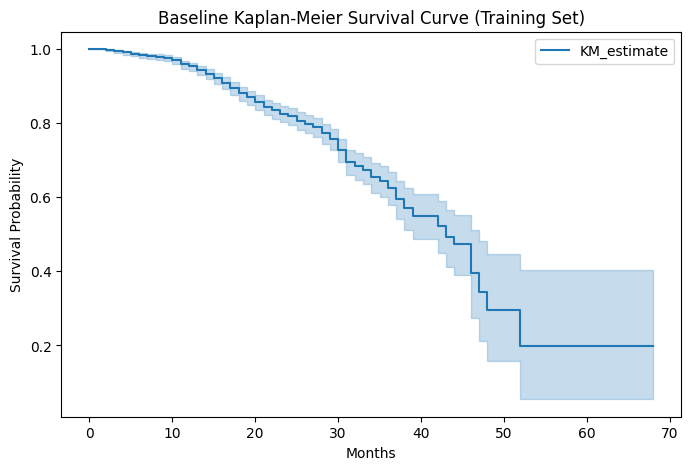

In [54]:
# Baseline Kaplan-Meier Survival Curve

kmf = KaplanMeierFitter()
kmf.fit(train_df['TimeInMonths'], event_observed=train_df['Status'])
plt.figure(figsize=(8,5))
kmf.plot_survival_function()
plt.title('Baseline Kaplan-Meier Survival Curve (Training Set)')
plt.xlabel('Months')
plt.ylabel('Survival Probability')
plt.show()

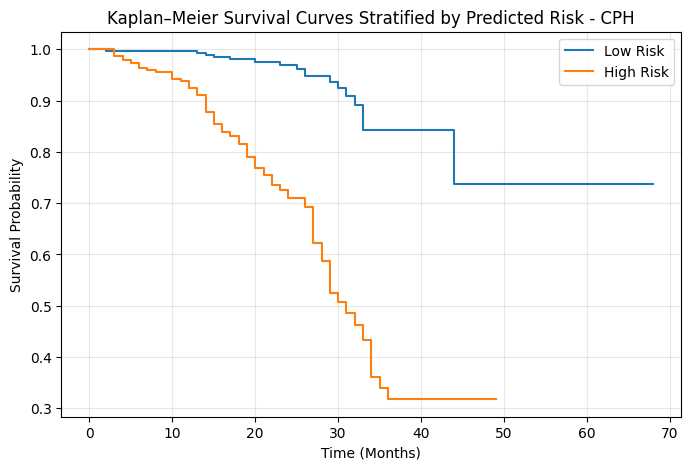

In [55]:
test_df["risk_score"] = cph.predict_partial_hazard(test_df)

median_risk = test_df["risk_score"].median()
test_df["risk_group"] = np.where(
    test_df["risk_score"] >= median_risk,
    "High Risk",
    "Low Risk"
)

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

for group in ["Low Risk", "High Risk"]:
    kmf = KaplanMeierFitter()
    mask = test_df["risk_group"] == group
    kmf.fit(
        test_df.loc[mask, "TimeInMonths"],
        event_observed=test_df.loc[mask, "Status"],
        label=group
    )
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan–Meier Survival Curves Stratified by Predicted Risk - CPH")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.grid(alpha=0.3)
plt.show()

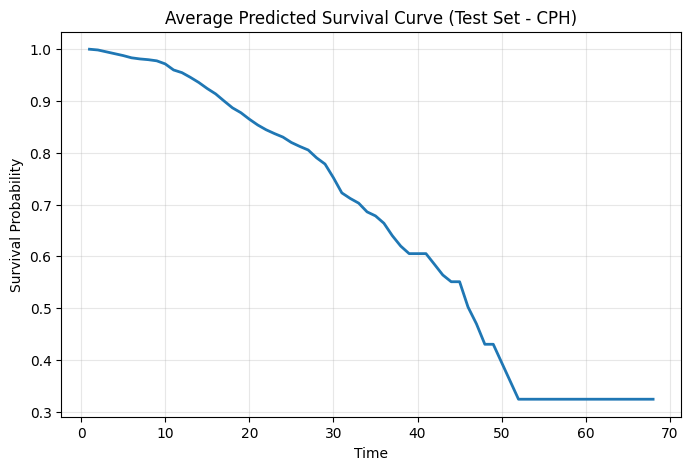

In [56]:
mean_survival = cph.predict_survival_function(
    test_df.drop(columns=["TimeInMonths", "Status"])
).mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(mean_survival.index, mean_survival.values, linewidth=2)
plt.title("Average Predicted Survival Curve (Test Set - CPH)")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(alpha=0.3)
plt.show()

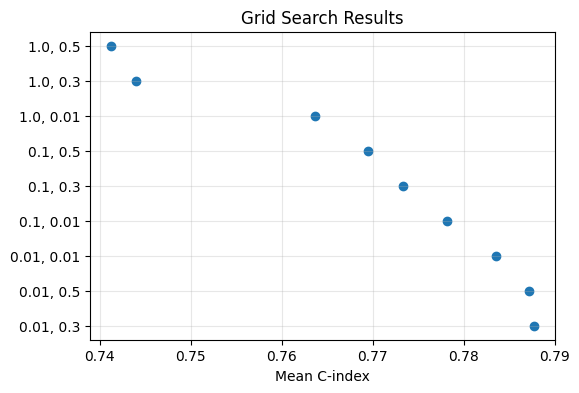

In [57]:
plt.figure(figsize=(6,4))

plt.scatter(
    results_df["mean_cindex"],
    range(len(results_df))
)

plt.yticks(
    range(len(results_df)),
    results_df[["penalizer","l1_ratio"]]
    .astype(str)
    .agg(", ".join, axis=1)
)

plt.xlabel("Mean C-index")
plt.title("Grid Search Results")
plt.grid(alpha=0.3)
plt.show()

In [58]:
# Hazard Ratios
hazard_ratios = np.exp(cph.params_)
print("Hazard Ratios (exp(coefficients)):")
print(hazard_ratios)


Hazard Ratios (exp(coefficients)):
covariate
Age                     1.000000
Grade                   1.364133
Surgery                 0.928982
Radiotherapy            1.000001
Chemotherapy            1.333685
Hormonetherapy          1.586923
Other                   0.247055
FamilyHistory           1.330554
NoTreatment             1.417534
Immunotherapy           1.891526
Sex                     1.043414
Topology_freq           3.758895
Morphology_freq         2.420208
DiagnosisMethod_freq    0.168927
I10_freq                0.240843
ICCC_freq               0.999993
Laterality_freq         0.060393
Name: coef, dtype: float64


In [59]:
import pickle

# Save the model using pickle
model_filename = 'model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(cph, f)
    print(f"Model saved to {model_filename}")

Model saved to model.pkl


In [60]:
# Save feature order
with open("train_columns.pkl", "wb") as f:
    pickle.dump(
        train_df.drop(columns=["TimeInMonths", "Status"]).columns.tolist(),
        f
    )

# Random Survival Forest

In [61]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, brier_score
from sksurv.util import Surv
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

In [62]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/CleanedData.csv")
df.head()

,Age,Topology,Morphology,DiagnosisMethod,I10,ICCC,Grade,Laterality,Surgery,Radiotherapy,Chemotherapy,Hormonetherapy,Other,FamilyHistory,NoTreatment,Immunotherapy,Sex,Status,TimeInMonths
0,1.229615,718,9440,7,C718,3b,7,8,1,1,1,1,1,0,1,3,1,0,30
1,-0.763632,719,9440,7,C719,3b,3,2,1,1,0,1,1,0,1,3,2,0,68
2,-0.165658,719,9440,7,C719,3b,3,1,1,1,0,1,1,0,1,3,2,0,68
3,-0.763632,719,9440,7,C719,3b,3,2,1,1,0,1,1,0,1,3,2,0,32
4,-0.896516,718,9401,7,C718,3b,7,2,1,1,1,1,1,0,1,3,1,0,31


In [63]:
from sklearn.model_selection import train_test_split

# Separate features and survival outcomes
X = df.drop(columns=["TimeInMonths", "Status"])
y_time = df["TimeInMonths"]
y_event = df["Status"]

# Ensure Status is binary (0=censored, 1=event)
y_event = y_event.apply(lambda x: 1 if x == 1 else 0)

# Split data
X_train, X_test, y_train_time, y_test_time, y_train_event, y_test_event = train_test_split(
    X,
    y_time,
    y_event,
    test_size=0.3,
    random_state=42,
    stratify=y_event
)

# Reattach survival columns
train_df = X_train.copy()
train_df["TimeInMonths"] = y_train_time
train_df["Status"] = y_train_event

test_df = X_test.copy()
test_df["TimeInMonths"] = y_test_time
test_df["Status"] = y_test_event

In [64]:
# Frequency Encoding
def frequency_encode(train_df, test_df, col):
    freq = train_df[col].value_counts(normalize=True)

    train_df[col + '_freq'] = train_df[col].map(freq)
    test_df[col + '_freq'] = test_df[col].map(freq).fillna(0)

    train_df.drop(columns=[col], inplace=True)
    test_df.drop(columns=[col], inplace=True)

    return train_df, test_df

categorical_cols = ['Topology', 'Morphology', 'DiagnosisMethod', 'I10', 'ICCC', 'Laterality']
for col in categorical_cols:
    train_df, test_df = frequency_encode(train_df, test_df, col)

train_df.head()

,Age,Grade,Surgery,Radiotherapy,Chemotherapy,Hormonetherapy,Other,FamilyHistory,NoTreatment,Immunotherapy,Sex,TimeInMonths,Status,Topology_freq,Morphology_freq,DiagnosisMethod_freq,I10_freq,ICCC_freq,Laterality_freq
213,0.830965,3,1,1,1,1,1,0,1,3,1,33,0,0.432931,0.143364,0.867282,0.422285,0.189496,0.189496
506,2.159797,7,1,1,1,1,1,0,1,3,2,13,1,0.432931,0.160397,0.064585,0.422285,0.165366,0.465578
723,-0.497866,7,1,1,1,1,1,0,1,3,1,36,0,0.432931,0.143364,0.867282,0.422285,0.189496,0.139106
568,-0.697191,2,1,0,0,1,1,0,1,3,2,10,1,0.176721,0.003549,0.867282,0.173172,0.558552,0.173882
1527,1.229615,3,1,1,1,1,1,0,1,3,1,11,0,0.432931,0.143364,0.867282,0.422285,0.189496,0.465578


In [65]:
from sksurv.util import Surv

X_train_rf = train_df.drop(columns=["TimeInMonths", "Status"])
X_test_rf  = test_df.drop(columns=["TimeInMonths", "Status"])

y_train_rf = Surv.from_dataframe(event="Status", time="TimeInMonths", data=train_df)
y_test_rf  = Surv.from_dataframe(event="Status", time="TimeInMonths", data=test_df)


In [66]:
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sksurv.metrics import concordance_index_censored

# Define C-index scorer
def c_index_scorer(y_true, y_pred):
    """
    y_true: structured array with fields ('Status', 'TimeInMonths')
    y_pred: predicted expected survival times from RSF
    """
    return concordance_index_censored(
        y_true['Status'],
        y_true['TimeInMonths'],
        y_pred
    )[0]

# Make scorer for RandomizedSearchCV
scorer = make_scorer(c_index_scorer, greater_is_better=True)

# RSF model
rsf = RandomSurvivalForest(n_jobs=-1, random_state=42)

# Hyperparameter grid
param_grid = {
    "n_estimators": [100, 300],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [3, 5],
    "max_features": ["sqrt"]
}

# Randomized search
rand_search = RandomizedSearchCV(
    estimator=rsf,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring=scorer,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit
rand_search.fit(X_train_rf, y_train_rf)

# Best estimator
best_rsf = rand_search.best_estimator_
print("Best RSF parameters:", rand_search.best_params_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:324: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best RSF parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}


In [67]:
from sksurv.metrics import concordance_index_censored
import numpy as np

# Concordance index
pred_train = best_rsf.predict(X_train_rf)
pred_test  = best_rsf.predict(X_test_rf)

c_index_train = concordance_index_censored(
    y_train_rf['Status'], y_train_rf['TimeInMonths'], pred_train
)[0]

c_index_test = concordance_index_censored(
    y_test_rf['Status'], y_test_rf['TimeInMonths'], pred_test
)[0]

print(f"C-index (train): {c_index_train:.3f}")
print(f"C-index (test): {c_index_test:.3f}")

#Brier score at specific times
times = [6, 12, 18, 24]
brier_scores = []

# Predict survival functions for all test samples
surv_funcs = best_rsf.predict_survival_function(X_test_rf)

for t in times:
    surv_probs_at_t = np.array([fn(t) for fn in surv_funcs])
    event_observed = (y_test_rf['TimeInMonths'] <= t) & (y_test_rf['Status'] == 1)
    brier = np.mean((event_observed.astype(int) - (1 - surv_probs_at_t))**2)
    brier_scores.append(brier)

# Print results
for t, score in zip(times, brier_scores):
    print(f"Brier score at {t} months: {score:.3f}")


C-index (train): 0.896
C-index (test): 0.819
Brier score at 6 months: 0.018
Brier score at 12 months: 0.034
Brier score at 18 months: 0.072
Brier score at 24 months: 0.092


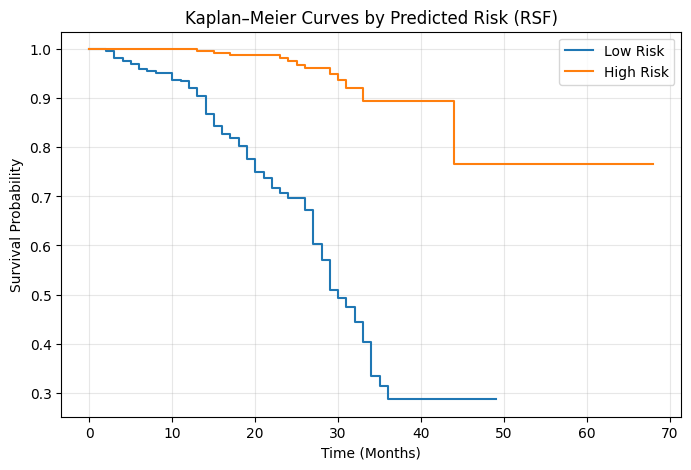

In [68]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np

# Predicted survival times from RSF
pred_surv_test = best_rsf.predict(X_test_rf)

# Define risk groups: lower predicted survival = high risk
median_risk = np.median(pred_surv_test)
risk_group = np.where(pred_surv_test <= median_risk, "High Risk", "Low Risk")

# Prepare test DataFrame for plotting
test_df_rf = X_test_rf.copy()
test_df_rf["TimeInMonths"] = y_test_rf['TimeInMonths']
test_df_rf["Status"] = y_test_rf['Status']
test_df_rf["risk_group"] = risk_group

# Plot KM curves by risk group
plt.figure(figsize=(8,5))
for group in ["Low Risk", "High Risk"]:
    kmf = KaplanMeierFitter()
    mask = test_df_rf["risk_group"] == group
    kmf.fit(
        test_df_rf.loc[mask, "TimeInMonths"],
        event_observed=test_df_rf.loc[mask, "Status"],
        label=group
    )
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan–Meier Curves by Predicted Risk (RSF)")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.grid(alpha=0.3)
plt.show()


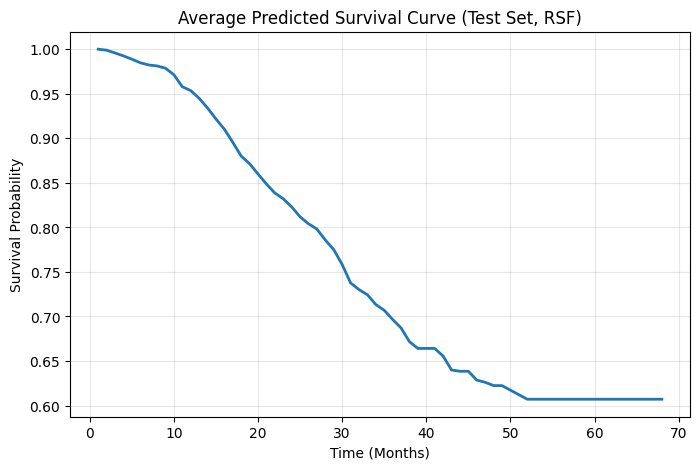

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Predict survival functions for all test samples
surv_funcs = best_rsf.predict_survival_function(X_test_rf)

# Get all unique time points across all survival functions
all_times = np.unique(np.concatenate([fn.x for fn in surv_funcs]))

# Evaluate survival probabilities for all samples at these times
all_surv_probs = np.column_stack([fn(all_times) for fn in surv_funcs])

# Average survival probability at each time point
mean_survival = all_surv_probs.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(all_times, mean_survival, linewidth=2)
plt.title("Average Predicted Survival Curve (Test Set, RSF)")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.grid(alpha=0.3)
plt.show()

# AFT (Accelerated Failure Time)

In [70]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from lifelines import WeibullAFTFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt

In [71]:
df = pd.read_csv("/content/CleanedData.csv")


X = df.drop(columns=["TimeInMonths", "Status"])
y_time = df["TimeInMonths"]
y_event = df["Status"]

# Ensure Status is binary (0=censored, 1=event)
y_event = y_event.apply(lambda x: 1 if x == 1 else 0)

# Split data
X_train, X_test, y_train_time, y_test_time, y_train_event, y_test_event = train_test_split(
    X,
    y_time,
    y_event,
    test_size=0.3,
    random_state=42,
    stratify=y_event
)

# Reattach survival columns
train_df = X_train.copy()
train_df["TimeInMonths"] = y_train_time
train_df["Status"] = y_train_event

test_df = X_test.copy()
test_df["TimeInMonths"] = y_test_time
test_df["Status"] = y_test_event

In [72]:
#  Frequency Encoding
def frequency_encode(train_df, test_df, col):
    freq = train_df[col].value_counts(normalize=True)

    train_df[col + '_freq'] = train_df[col].map(freq)
    test_df[col + '_freq'] = test_df[col].map(freq).fillna(0)

    train_df.drop(columns=[col], inplace=True)
    test_df.drop(columns=[col], inplace=True)

    return train_df, test_df

categorical_cols = ['Topology', 'Morphology', 'DiagnosisMethod', 'I10', 'ICCC', 'Laterality']
for col in categorical_cols:
    train_df, test_df = frequency_encode(train_df, test_df, col)

In [73]:
# Fit Weibull AFT Model
aft = WeibullAFTFitter()
aft.fit(train_df, duration_col='TimeInMonths', event_col='Status')

print("Weibull AFT Summary")
aft.print_summary()

Weibull AFT Summary


<lifelines.WeibullAFTFitter: fitted with 1409 total observations, 1102 right-censored observations>
             duration col = 'TimeInMonths'
                event col = 'Status'
   number of observations = 1409
number of events observed = 307
           log-likelihood = -1498.70
         time fit was run = 2026-02-04 06:18:11 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                             
lambda_ Age                   0.01      1.01      0.03           -0.04            0.06                0.96                1.06
        Chemotherapy         -0.21      0.81      0.11           -0.42            0.01                0.66                1.01
        DiagnosisMethod_freq  0.88      2.40      0.09            0.70            1.05                2.01                2.87
        FamilyHistory        -0.14      0.87      0.05           -0.25           -0.04                0.78                0.96
        Grade                -0.16      0.86      0.02           -0.20           -0.11                0.82                0.89
        Hormonetherapy       -0.38      0.68      0.59           -1.53            0.77                0.22                2.16
        I10_freq              1.78      5.94      0.43            0.94            2.62                2.56               13.78
        ICCC_freq            -0.04      0.96      0.19           -0.40            0.33                0.67                1.39
        Immunotherapy        -3.68      0.03    785.93        -1544.07         1536.71                0.00                 inf
        Laterality_freq       1.40      4.07      0.20            1.00            1.80                2.73                6.06
        Morphology_freq      -0.60      0.55      0.28           -1.14           -0.05                0.32                0.95
        NoTreatment          -0.19      0.83      0.12           -0.42            0.04                0.66                1.04
        Other                 0.84      2.31      0.38            0.09            1.59                1.09                4.89
        Radiotherapy          0.01      1.01      0.11           -0.22            0.23                0.80                1.26
        Sex                  -0.02      0.98      0.05           -0.13            0.08                0.88                1.08
        Surgery               0.10      1.10      0.10           -0.09            0.29                0.91                1.34
        Topology_freq        -1.75      0.17      0.43           -2.59           -0.92                0.08                0.40
        Intercept            14.90  2.96e+06   2357.78        -4606.27         4636.07                0.00                 inf
rho_    Intercept             0.80      2.22      0.05            0.70            0.89                2.02                2.43

                              cmp to     z      p  -log2(p)
param   covariate                                          
lambda_ Age                     0.00  0.35   0.73      0.46
        Chemotherapy            0.00 -1.85   0.06      3.94
        DiagnosisMethod_freq    0.00  9.67 <0.005     71.01
        FamilyHistory           0.00 -2.67   0.01      7.05
        Grade                   0.00 -7.21 <0.005     40.68
        Hormonetherapy          0.00 -0.65   0.52      0.96
        I10_freq                0.00  4.14 <0.005     14.83
        ICCC_freq               0.00 -0.19   0.85      0.24
        Immunotherapy           0.00 -0.00   1.00      0.01
        Laterality_freq         0.00  6.89 <0.005     37.39
        Morphology_freq         0.00 -2.14   0.03      4.95
        NoTreatment             0.00 -1.60   0.11      3.19
        Other                   0.00  2.18   0.03      5.11
        Radiotherapy            0.00  0.05   0.96      0.06
        Sex                     0

In [74]:
from lifelines.utils import concordance_index

# Use expected survival time for risk ordering
c_index_train = concordance_index(
    train_df['TimeInMonths'],
    aft.predict_expectation(train_df),
    train_df['Status']
)

c_index_test = concordance_index(
    test_df['TimeInMonths'],
    aft.predict_expectation(test_df),
    test_df['Status']
)

print(f"C-index (train): {c_index_train:.3f}")
print(f"C-index (test): {c_index_test:.3f}")


# Brier score at specific times
times = [6, 12, 18, 24]
brier_scores = []

for t in times:
    surv_probs = aft.predict_survival_function(test_df, times=[t]).T.squeeze()
    event_observed = (test_df['TimeInMonths'] <= t) & (test_df['Status'] == 1)
    brier = np.mean((event_observed.astype(int) - (1 - surv_probs))**2)
    brier_scores.append(brier)

for t, score in zip(times, brier_scores):
    print(f"Brier score at {t} months: {score:.3f}")


C-index (train): 0.794
C-index (test): 0.780
Brier score at 6 months: 0.020
Brier score at 12 months: 0.037
Brier score at 18 months: 0.079
Brier score at 24 months: 0.104


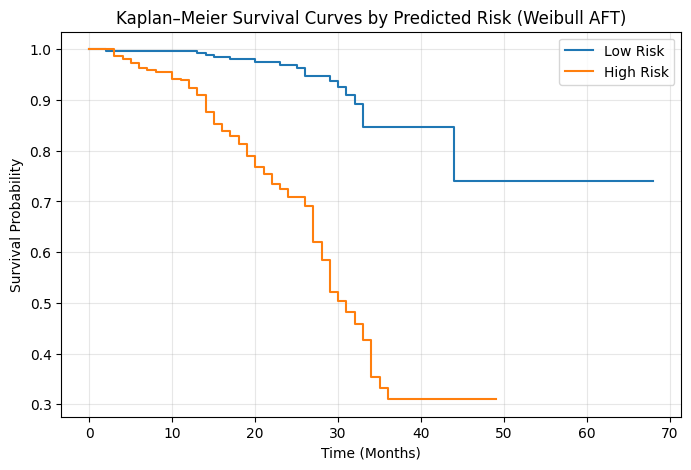

In [75]:
# Kaplan-Meier Curves by Risk Group

test_df["risk_score"] = -aft.predict_median(test_df)
median_risk = test_df["risk_score"].median()
test_df["risk_group"] = np.where(test_df["risk_score"] >= median_risk, "High Risk", "Low Risk")

plt.figure(figsize=(8,5))
for group in ["Low Risk", "High Risk"]:
    kmf = KaplanMeierFitter()
    mask = test_df["risk_group"] == group
    kmf.fit(
        test_df.loc[mask, "TimeInMonths"],
        event_observed=test_df.loc[mask, "Status"],
        label=group
    )
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan–Meier Survival Curves by Predicted Risk (Weibull AFT)")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.grid(alpha=0.3)
plt.show()

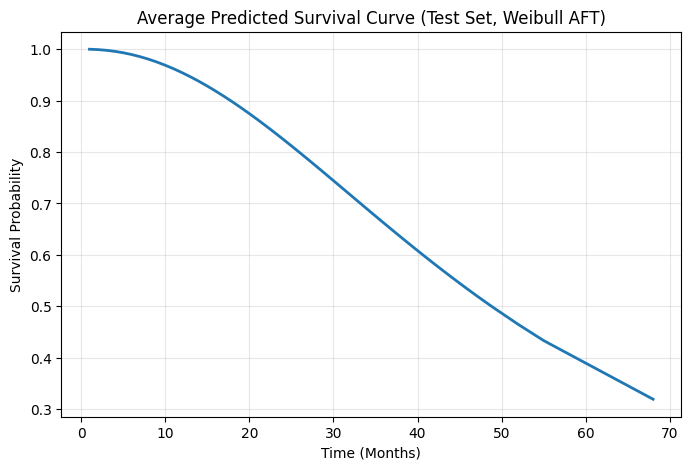

In [76]:
# Average Predicted Survival Curve
surv_funcs = aft.predict_survival_function(test_df)
mean_survival = surv_funcs.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(mean_survival.index, mean_survival.values, linewidth=2)
plt.title("Average Predicted Survival Curve (Test Set, Weibull AFT)")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.grid(alpha=0.3)
plt.show()


In [77]:
# Time Ratios (Interpret Coefficients)
time_ratios = np.exp(aft.params_.loc['lambda_'])
print("Time Ratios (exp(coefficients)):")
print(time_ratios)

Time Ratios (exp(coefficients)):
covariate
Age                     1.009365e+00
Chemotherapy            8.145725e-01
DiagnosisMethod_freq    2.399214e+00
FamilyHistory           8.654448e-01
Grade                   8.563194e-01
Hormonetherapy          6.824584e-01
I10_freq                5.935229e+00
ICCC_freq               9.648946e-01
Immunotherapy           2.522344e-02
Laterality_freq         4.067738e+00
Morphology_freq         5.506215e-01
NoTreatment             8.272463e-01
Other                   2.308382e+00
Radiotherapy            1.005642e+00
Sex                     9.775438e-01
Surgery                 1.104148e+00
Topology_freq           1.731080e-01
Intercept               2.960613e+06
dtype: float64
